# House Prices - Advanced Regression Techniques
*Predict sales prices and practice feature engineering, RFs, and gradient boosting*

In [2336]:
# TODO: apply all this transformations for train & test datasets, and then split again
# TODO: make boxcox run! (maybe just for a few ft.?)
# TODO: use other regression models
# TODO: try with AmesHousing.csv!!!
# TODO: reduce overfitting on GradientBoostingRegressor (after testing with leaked file)

In [2337]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from enum import Enum

# Set the aesthetics for the plots
sns.set(style="whitegrid", palette="muted")

RANDOM_STATE = 101


class ScalerType(Enum):
    STANDARD = "standard"
    ROBUST = "robust"

### Data collection

In [2338]:
df_train = pd.read_csv("./data/train.csv")
pd.concat([df_train.head(2), df_train.tail(2)])

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


### EDA

In [2339]:
df_train.shape

(1460, 81)

In [2340]:
def show_missing_data(df):
    """
    Display number and percentage of columns with any missing value
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (
        ((df.isnull().sum() / df.isnull().count()) * 100)
        .sort_values(ascending=False)
        .round(2)
    )
    missing_data = pd.concat([total, percent], axis=1, keys=["# missing", "% missing"])
    print(missing_data[missing_data["# missing"] > 0])


show_missing_data(df_train)

              # missing  % missing
PoolQC             1453      99.52
MiscFeature        1406      96.30
Alley              1369      93.77
Fence              1179      80.75
MasVnrType          872      59.73
FireplaceQu         690      47.26
LotFrontage         259      17.74
GarageYrBlt          81       5.55
GarageCond           81       5.55
GarageType           81       5.55
GarageFinish         81       5.55
GarageQual           81       5.55
BsmtFinType2         38       2.60
BsmtExposure         38       2.60
BsmtQual             37       2.53
BsmtCond             37       2.53
BsmtFinType1         37       2.53
MasVnrArea            8       0.55
Electrical            1       0.07


- `PoolQC`=NA means no pool
- `MiscFeature`=NA means there are no extra features (e.g.: Elevator, Tennis Court..)
- `Alley`=NA means no alley access
- `Fence`=NA means no fence
- `MasVnrType`=NA means None
- `FireplaceQu`=NA means no Fireplace

<Figure size 1000x1000 with 0 Axes>

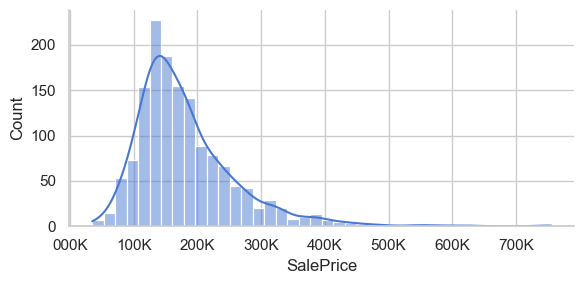

In [2341]:
plt.figure(figsize=(10, 10))
sns.displot(df_train["SalePrice"] / 100000, bins=40, kde=True, height=3, aspect=2)
plt.xticks(ticks=[i for i in range(0, 8)], labels=[f"{i}00K" for i in range(0, 8)])
plt.show()

ℹ️ Careful -> skewed distribution of price

- In statistical analysis, a non-skewed distribution is typically a normal distribution, which resembles a bell curve when graphed. This means it's symmetric, with most of the observations clustering around the central peak and the probabilities for values further away from the mean tapering off equally in both directions.

- If we don't apply a log transformation to SalePrice when it's skewed, our model may not perform as well, especially if it assumes that the residuals (errors) are normally distributed, as many linear models do. Applying a log transformation can help stabilize the variance across the data range and make the data conform more closely to the assumptions of parametric statistical tests, leading to more reliable statistical inference and potentially better model performance. If a log transformation is applied, the distribution should look more like a normal distribution, with fewer outliers and a more symmetric shape.

- When should log **NOT** be applied to the target variable?
  - The distribution of the target variable is already close to normal. Log transformation in such cases might lead to a worse fit.
  - The model you're using is robust to non-normality, like tree-based models (e.g., decision trees, random forests).
  - The range of the target variable is narrow with low variance, so the proportional differences are minimal.
  - You have a binary or categorical target variable. In classification problems, log transformation is not applicable.
  - The relationship between predictors and the target is linear, and there are no signs of heteroscedasticity (uneven spread of residuals).

### Data cleaning & Preprocessing

In [2419]:
def fill_nulls(df):
    # convert numerical (but actually categorical) features to str
    df[["MSSubClass", "YrSold", "MoSold"]] = df[
        ["MSSubClass", "YrSold", "MoSold"]
    ].astype(str)

    # fill NA with default values
    df["Fence"] = df["Fence"].fillna("NoFence")
    df["Alley"] = df["Alley"].fillna("NoAlleyAccess")
    df["MiscFeature"] = df["MiscFeature"].fillna("None")
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["FireplaceQu"] = df["FireplaceQu"].fillna("NoFireplace")

    # fill NA with 0
    for col in (
        "MasVnrArea",
        "TotalBsmtSF",
        "BsmtUnfSF",
        "BsmtFullBath",
        "BsmtHalfBath",
        "BsmtFinSF1",
        "BsmtFinSF2",
        "GarageCars",
        "GarageArea",
    ):
        df[col] = df[col].fillna(0)

    # fill NA for basement
    for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
        df[col] = df[col].fillna("None")

    # fill NA for garage
    df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["YearBuilt"])
    garage_columns = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
    df[garage_columns] = df[garage_columns].fillna("NoGarage")

    # fill NA based on mode/median
    # (Mean is sensitive to outliers, whereas median is more robust)
    df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])  # 'SBrkr'
    df["Functional"] = df["Functional"].fillna(df["Functional"].mode()[0])  # 'Typ'
    df["KitchenQual"] = df["KitchenQual"].fillna(df["KitchenQual"].mode()[0])  # 'TA'
    df["SaleType"] = df["SaleType"].fillna(df["SaleType"].mode()[0])  # 'WD'
    df["MSZoning"] = df.groupby("MSSubClass")["MSZoning"].transform(
        lambda x: x.fillna(x.mode()[0])
    )

    # df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    #     lambda x: x.fillna(x.median())
    # )

    # assign median to Neighborhoods Without LotFrontage data
    lot_frontage_median = df["LotFrontage"].median()
    df.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median() if not x.isna().all() else lot_frontage_median)
    )

    # remove outliers (no clue why, but worth investigating..)
    df = df.drop(index=[30, 88, 462, 631, 1322, 523, 691, 1182, 1298])
    df = df[df.GrLivArea < 4500].reset_index(drop=True)

    return df

### Feature Engineering

In [2343]:
# adding binary vars (are often easier to interpret for models than continuous ft.)
# E.g. hypothesis:
# - instead of knowing the exact size of the pool, the model just needs to know
#   whether there's a pool or not.
# - having a pool might increase a house's value disproportionately, regardless
#   of the pool's size
def add_binary_features(df):
    df["haspool"] = df["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
    df["has2ndfloor"] = df["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
    df["hasgarage"] = df["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
    df["hasbsmt"] = df["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
    df["hasfireplace"] = df["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

    return df

In [2344]:
# adding new features:


def add_aggr_features(df):
    # combined effect of the age of the house and the recency of any remodeling:
    # recently remodeled older house could be more valuable than an old house that
    # hasn't been updated
    df["YrBltAndRemod"] = df["YearBuilt"] + df["YearRemodAdd"]

    # total square footage of the house might be better indicator than individual
    # measurements, as it gives a holistic view of the size of the house.
    df["TotalSF"] = (
        df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    )

    # same as above for total ^2 footage across different levels of the house.
    df["Total_sqr_footage"] = (
        df["BsmtFinSF1"]
        + df["BsmtFinSF2"]
        + df["1stFlrSF"]
        + df["2ndFlrSF"]
    )

    # aggregates all types of bathrooms: full baths (with a shower or bathtub) are
    # generally more valuable than half baths.
    df["Total_Bathrooms"] = (
        df["FullBath"]
        + (0.5 * df["HalfBath"])
        + df["BsmtFullBath"]
        + (0.5 * df["BsmtHalfBath"])
    )

    # combines all types of porches and decks to give an overall measure of the outdoor
    # living space: Outdoor spaces can add significant value to a property.
    df["Total_porch_sf"] = (
        df["OpenPorchSF"]
        + df["3SsnPorch"]
        + df["EnclosedPorch"]
        + df["ScreenPorch"]
        + df["WoodDeckSF"]
    )

    return df

In [2390]:
def remove_features(df):
    # remove unnecessary features or with very low variance
    # ignore errors because train.csv &  AmesHousing.csv have different ID fields
    df.drop(
        [
            "Id",
            "Street",
            "Utilities",
            "PoolQC",
            "Order",
            "PID",
        ],
        axis=1,
        inplace=True,
        errors="ignore",
    )

    # ℹ️ dimensionality reduction: removing the original features and keeping only
    # the new ones improve the scores (probably because there is a bunch of ft!)
    df.drop(
        [
            "YearBuilt",
            "YearRemodAdd",
            "1stFlrSF",
            "2ndFlrSF",
            "BsmtFinSF1",
            "BsmtFinSF2",
            "FullBath",
            "HalfBath",
            "BsmtFullBath",
            "BsmtHalfBath",
            "OpenPorchSF",
            "3SsnPorch",
            "EnclosedPorch",
            "ScreenPorch",
            "WoodDeckSF",
        ],
        axis=1,
        inplace=True,
    )

    return df

### Process dataset

In [2346]:
# Process TRAIN data
df_train = fill_nulls(df_train)
df_train = add_binary_features(df_train)
df_train = add_aggr_features(df_train)
df_train = remove_features(df_train)

# check if all nulls are handled
show_missing_data(df_train)

Empty DataFrame
Columns: [# missing, % missing]
Index: []


### Encoding categorical data

In [2348]:
def encode_features(df):
    """Encode categorical features"""
    columns_to_encode = df.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    encoded_df_train = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

    # replace spaces in df columns for lightxgb model
    encoded_df_train.columns = encoded_df_train.columns.str.replace(" ", "_")

    return encoded_df_train

### Split dataset into Train/Test data

In [2349]:
from sklearn.preprocessing import StandardScaler, RobustScaler


def scale_features(df: any, scaler_type: ScalerType):
    scaler = RobustScaler() if scaler_type == ScalerType.ROBUST else StandardScaler()
    numerical_cols = df.select_dtypes(
        include=["int16", "int32", "int64", "float16", "float32", "float64"]
    ).columns
    X_scaled = df.copy()
    X_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return X_scaled

In [2350]:
from sklearn.model_selection import train_test_split

X = encode_features(df_train).drop("SalePrice", axis=1)
X = scale_features(X, ScalerType.ROBUST)
# X = apply_yeojohnson(df_train.drop("SalePrice", axis=1))

y = np.log1p(df_train["SalePrice"]) # log transformation

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

☝🏻 Robust scaler performs better than standard

### Regression Models

In [2351]:
from xgboost import XGBRegressor


def fit_xgb_regressor(
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.3,
    max_depth=6,
    min_child_weight=1,
    n_estimators=100,
    objective="reg:squarederror",
    reg_alpha=0,
    scale_pos_weight=1,
    subsample=1,
):
    xgb = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective=objective,
        nthread=-1,
        scale_pos_weight=scale_pos_weight,
        seed=RANDOM_STATE,
        reg_alpha=reg_alpha,
    )
    xgb.fit(X_train, y_train)
    return xgb

In [2352]:
from sklearn.linear_model import Ridge


def fit_ridge_regressor(
    alpha=1.0,
    fit_intercept=True,
    max_iter=None,
    tol=0.0001,
):
    ridge = Ridge(
        alpha=alpha,
        fit_intercept=fit_intercept,
        copy_X=True,
        max_iter=max_iter,
        tol=tol,
        random_state=RANDOM_STATE,
    )
    ridge.fit(X_train, y_train)
    return ridge

In [2353]:
from sklearn.linear_model import Lasso


def fit_lasso_regressor(
    alpha=1.0,
    fit_intercept=True,
    max_iter=1000,
    positive=False,
    precompute=False,
    selection="cyclic",
    tol=0.0001,
    warm_start=False,
):
    lasso = Lasso(
        alpha=alpha,
        fit_intercept=fit_intercept,
        precompute=precompute,
        copy_X=True,
        max_iter=max_iter,
        tol=tol,
        warm_start=warm_start,
        positive=positive,
        random_state=RANDOM_STATE,
        selection=selection,
    )
    lasso.fit(X_train, y_train)
    return lasso

In [2354]:
from sklearn.linear_model import ElasticNet


def fit_elastic_net_regressor(
    alpha=1.0,
    fit_intercept=True,
    l1_ratio=0.5,
    max_iter=1000,
    positive=False,
    precompute=False,
    selection="cyclic",
    tol=0.0001,
    warm_start=False,
):
    enet = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        fit_intercept=fit_intercept,
        precompute=precompute,
        max_iter=max_iter,
        copy_X=True,
        tol=tol,
        warm_start=warm_start,
        positive=positive,
        random_state=RANDOM_STATE,
        selection=selection,
    )
    enet.fit(X_train, y_train)
    return enet

In [2355]:
import lightgbm as lgb


def fit_lightgbm_regressor(
    bagging_fraction=1.0,
    bagging_freq=0,
    colsample_bytree=1.0,
    force_row_wise=False,
    importance_type="split",
    learning_rate=0.1,
    max_bin=255,
    max_depth=-1,
    min_child_samples=20,
    min_split_gain=0.0,
    n_estimators=100,
    num_leaves=31,
    objective="regression",
    reg_alpha=0.0,
    reg_lambda=0.0,
    # subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
    verbose=1,
):
    lgbm = lgb.LGBMRegressor(
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        bagging_seed=RANDOM_STATE,
        colsample_bytree=colsample_bytree,
        force_row_wise=force_row_wise,
        importance_type=importance_type,
        learning_rate=learning_rate,
        max_bin=max_bin,
        max_depth=max_depth,
        min_split_gain=min_split_gain,
        min_child_samples=min_child_samples,
        n_estimators=n_estimators,
        n_jobs=-1,
        num_leaves=num_leaves,
        objective=objective,
        random_state=RANDOM_STATE,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        # subsample=subsample,
        subsample_for_bin=subsample_for_bin,
        subsample_freq=subsample_freq,
        verbose=verbose,
    )
    lgbm.fit(X_train, y_train)
    return lgbm

In [2356]:
from sklearn.ensemble import GradientBoostingRegressor


def fit_gradient_boosting_regressor(
    learning_rate=0.1,
    loss='squared_error',
    max_depth=3,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    subsample=1.0,
):
    gb = GradientBoostingRegressor(
        loss=loss,
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=RANDOM_STATE,
        subsample=subsample,
    )
    gb.fit(X_train, y_train)
    return gb

### Fit Models

In [2357]:
# train regressors with default values
xgb = fit_xgb_regressor()
ridge = fit_ridge_regressor()
lasso = fit_lasso_regressor()
enet = fit_elastic_net_regressor()
lgbm = fit_lightgbm_regressor(verbose=-1)
gb = fit_gradient_boosting_regressor()

### Evaluation Functions

In [2358]:
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# def evaluate_models(regressors, cv=10):
#     results = []
#     kfolds = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
#     for regressor in regressors:
#         y_pred = regressor.predict(X_test)
#         r2 = r2_score(y_test, y_pred)
#         mae = mean_absolute_error(y_test, y_pred)
#         mse = mean_squared_error(y_test, y_pred)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         rmse_cv = np.sqrt(
#             -cross_val_score(
#                 regressor, X, y, scoring="neg_mean_squared_error", cv=kfolds
#             )
#         )
#         results.append(
#             {
#                 "Model": type(regressor).__name__,
#                 "MAE": mae,
#                 "MSE": mse,
#                 "RMSE": rmse,
#                 "RMSEcv": rmse_cv.mean(),
#                 "R^2": r2,
#             }
#         )
#     sorted_results = sorted(results, key=lambda x: x["RMSEcv"], reverse=False)
#     print(f"{'Model':<25} {'RMSEcv':<11} {'RMSE':<11} {'MAE':<8} {'MSE':<8} {'R^2':<8}")
#     print("-" * 72)
#     for result in sorted_results:
#         metrics = f"{result['RMSEcv']:<11.5f} {result['RMSE']:<11.5f} "
#         metrics += f"{result['MAE']:<8.2f} {result['MSE']:<8.2f} {result['R^2']:<8.2f}"
#         print(f"{result['Model']:<25} {metrics}")

In [2359]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate_models(regressors, X, y, cv=10):
    results = []
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    for regressor in regressors:
        y_pred = regressor.predict(X)
        r2 = r2_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        rmse_cv = np.sqrt(
            -cross_val_score(
                regressor, X, y, scoring="neg_mean_squared_error", cv=kfolds
            )
        )
        results.append(
            {
                "Model": type(regressor).__name__,
                "MAE": mae,
                "MSE": mse,
                "RMSE": rmse,
                "RMSEcv": rmse_cv.mean(),
                "R^2": r2,
            }
        )
    sorted_results = sorted(results, key=lambda x: x["RMSEcv"], reverse=False)
    print(f"{'Model':<25} {'RMSEcv':<11} {'RMSE':<11} {'MAE':<8} {'MSE':<8} {'R^2':<8}")
    print("-" * 72)
    for result in sorted_results:
        metrics = f"{result['RMSEcv']:<11.5f} {result['RMSE']:<11.5f} "
        metrics += f"{result['MAE']:<8.2f} {result['MSE']:<8.2f} {result['R^2']:<8.2f}"
        print(f"{result['Model']:<25} {metrics}")

In [2360]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_learning_curve(
    estimator,
    X= X,
    y = y,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    fig_size=(6, 4),
):
    plt.figure(figsize=fig_size)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=n_jobs,
        train_sizes=train_sizes,
    )

    # Take the negative of the scores because 'neg_mean_squared_error' is used
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

    sns.lineplot(x=train_sizes, y=train_scores_mean, label="Training score")
    sns.lineplot(x=train_sizes, y=test_scores_mean, label="Cross-validation score")

    plt.title(f"Learning Curve (RMSE) - {type(estimator).__name__}")
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

In [2361]:
from sklearn.model_selection import GridSearchCV


def evaluate_model_grid_search_cv(
    regressor,
    X_train,
    y_train,
    params,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
):
    grid_search = GridSearchCV(
        estimator=regressor, param_grid=params, scoring=scoring, cv=cv, n_jobs=n_jobs
    )
    grid_search.fit(X=X_train, y=y_train)
    best_score = np.sqrt(-grid_search.best_score_)
    best_params = grid_search.best_params_
    print(f"Model: {type(regressor).__name__}")
    print(f" - Best RMSE: {best_score}")
    print(f" - Best params: {best_params}")

### Evaluate Models

In [2362]:
models = [xgb, ridge, lasso, enet, lgbm, gb]
evaluate_models(models, X_test, y_test, 2)

Model                     RMSEcv      RMSE        MAE      MSE      R^2     
------------------------------------------------------------------------
Ridge                     0.13224     0.11579     0.08     0.01     0.92    
GradientBoostingRegressor 0.15578     0.11152     0.08     0.01     0.93    
LGBMRegressor             0.15841     0.11338     0.08     0.01     0.93    
XGBRegressor              0.17189     0.12338     0.09     0.02     0.91    
Lasso                     0.42599     0.41668     0.33     0.17     -0.00   
ElasticNet                0.42908     0.41683     0.33     0.17     -0.00   


In [2363]:
# plot_learning_curve(xgb)

### Tune Models

### XGB

In [2364]:
# params = {
#     "colsample_bytree": [0.7],
#     "gamma": [0],
#     "learning_rate": [0.01, 0.05],
#     "max_depth": [2, 3],
#     "min_child_weight": [0],
#     "n_estimators": [2500, 3460],
#     "objective": ["reg:squarederror"],
#     "reg_alpha": [0.00006],
#     "scale_pos_weight": [1],
#     "subsample": [0.7, 0.8],
# }

# evaluate_model_grid_search_cv(xgb, X_train, y_train, params, 5)

In [2365]:
# xgb = fit_xgb_regressor(
#     0.01, 3460, 3, 0, 0, 0.7, 0.7, "reg:squarederror", 1, 0.00006
# )  # rmse: 0.12
xgb = fit_xgb_regressor(
    colsample_bytree=0.7,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=0,
    n_estimators=3460,
    objective="reg:squarederror",
    reg_alpha=0.00006,
    scale_pos_weight=1,
    subsample=0.7,
)

### Ridge

In [2366]:
params = {
    "alpha": [12.8, 12.9, 13],
    "fit_intercept": [True, False],
    "max_iter": [None, 500, 1000, 5000],
    "tol": [0.000001, 0.0000025, 0.000005, 0.00001, 0.00002],
}


evaluate_model_grid_search_cv(ridge, X_train, y_train, params, 10)

Model: Ridge
 - Best RMSE: 0.11250925420687193
 - Best params: {'alpha': 13, 'fit_intercept': True, 'max_iter': None, 'tol': 1e-06}


In [2367]:
ridge = fit_ridge_regressor(
    alpha=13,
    fit_intercept=True,
    max_iter=None,
    tol=0.000005,
)

### Lasso

In [2368]:
# params = {
#     "alpha": [0.0001, 0.001], 
#     "fit_intercept": [True, False],
#     "max_iter": [1000, 2000],
#     "positive": [False, True],
#     "precompute": [False, True],
#     "tol": [0.00001, 0.0001],
#     "selection": ["cyclic", "random"],
#     "warm_start": [False, True],
# }


# evaluate_model_grid_search_cv(lasso, X_train, y_train, params, 10)

In [2369]:
lasso = fit_lasso_regressor(
    alpha=0.0001,
    fit_intercept=True,
    max_iter=7500,
    positive=True,
    precompute=False,
    selection="random",
    tol=0.00001,
    warm_start=False,
)

### Elastic Net

In [2370]:
# params = {
#     "alpha": [0.0001, 0.00015, 0.0002],
#     "fit_intercept": [True],
#     "l1_ratio": [0.8, 0.9],
#     "max_iter": [12000],
#     "positive": [True],
#     "precompute": [False, True],
#     "selection": ["cyclic", "random"],
#     "tol": [0.000001, 0.00001],
#     "warm_start": [False],
# }

# evaluate_model_grid_search_cv(enet, X_train, y_train, params, 10)

In [2371]:
enet = fit_elastic_net_regressor(
    alpha=0.00015,
    fit_intercept=True,
    l1_ratio=0.8,
    max_iter=12000,
    positive=True,
    precompute=False,
    selection="random",
    tol=0.00001,
    warm_start=False,
)

### LightGBM

In [2372]:
params = {
    "bagging_fraction": [0.8], # 0.8 in 0.9,1.0
    "bagging_freq": [4], # 4 in 0,4
    "colsample_bytree": [0.8], # 0.8 in 0.9
    "importance_type": ["split"], # "gain"
    "force_row_wise": [True], # False
    "learning_rate": [0.01],
    "max_bin": [200], # set to 200!!
    "max_depth": [-1],
    "min_child_samples": [10], ## !! decreasing it increases a lot the running time
    "min_split_gain": [0.0], # gets 0.1 from 0.1, 0.2, 0.3
    "n_estimators": [2000],
    "num_leaves": [4], # set to 4!!
    "objective": ["regression"],
    "reg_alpha": [0.0],
    "reg_lambda": [0.0],
    # "subsample": [0.8], # remove if using bagging
    "subsample_for_bin": [200000],
    "subsample_freq": [0],
    "verbose": [-1], # only warnings
}

# evaluate_model_grid_search_cv(lgbm, X_train, y_train, params, 10)

In [2373]:
lgbm = fit_lightgbm_regressor(
    bagging_fraction=0.8,
    bagging_freq=4,
    colsample_bytree=0.8,
    force_row_wise=True,
    importance_type='split',
    learning_rate=0.01,
    max_bin=200,
    max_depth=-1,
    min_split_gain=0.0,
    min_child_samples=10,
    n_estimators=6000,
    num_leaves=4,
    objective="regression",
    reg_alpha=0.0,
    reg_lambda=0.0,
    subsample_for_bin=200000,
    subsample_freq=0,
    verbose=-1,
)

### Gradient Boosting

In [2374]:
params = {
    "loss": ['squared_error', 'huber'],
    "n_estimators": [2000],
    "learning_rate": [0.01],
    "max_depth": [4],
    "min_samples_leaf": [7, 8, 9],
    "min_samples_split": [2, 3],
    "subsample": [0.9],
    "max_features": ['sqrt'], 
}

# evaluate_model_grid_search_cv(gb, X_train, y_train, params, 5)

In [2375]:
gb = fit_gradient_boosting_regressor(
    loss='huber',
    learning_rate=0.01,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=8,
    n_estimators=3000,
    subsample=0.9,
)

"""
TO PREVENT OVERFITTING
"""
# gb = fit_gradient_boosting_regressor(
#     loss='huber',
#     learning_rate=0.005,  # Decreased
#     max_depth=3,  # Decreased
#     max_features='sqrt',
#     min_samples_leaf=4,  # Increased
#     min_samples_split=10,  # Increased
#     n_estimators=3000,  # Decreased
#     subsample=0.7,  # Decreased
#     validation_fraction=0.1,  # For early stopping
#     n_iter_no_change=20  # For early stopping
# )



# quite overfitting, so will have to lower it although score decreases

'\nTO PREVENT OVERFITTING\n'

### Scores with tunned models on Train data

In [2376]:
models = [xgb, ridge, lasso, enet, gb] # excluding lgbm for now, takes some time.
evaluate_models(models, X_train, y_train, 10)

Model                     RMSEcv      RMSE        MAE      MSE      R^2     
------------------------------------------------------------------------
ElasticNet                0.10762     0.09262     0.07     0.01     0.94    
Lasso                     0.10763     0.09190     0.07     0.01     0.94    
GradientBoostingRegressor 0.11118     0.05337     0.03     0.00     0.98    
XGBRegressor              0.11142     0.04353     0.03     0.00     0.99    
Ridge                     0.11168     0.09509     0.07     0.01     0.94    


In [2377]:
# plot_learning_curve(xgb)

In [2378]:
# plot_learning_curve(gb)

### Kaggle check

In [2422]:
df_test = pd.read_csv("./data/AmesHousing.csv")
df_test.head(2)

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000


In [2423]:
# Process TEST data
df_test = fill_nulls(df_test)
df_test = add_binary_features(df_test)
df_test = add_aggr_features(df_test)
df_test = remove_features(df_test)

# check if all nulls are handled
show_missing_data(df_test)

             # missing  % missing
LotFrontage        487      16.69


In [2425]:
X_test = encode_features(df_test).drop("SalePrice", axis=1)
X_test = scale_features(X_test, ScalerType.ROBUST)

y_test = np.log1p(df_test["SalePrice"])

evaluate_models(models, X_test, y_test, 2) # needs params x & y


In [ ]:
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

def apply_boxcox(df):
    """
    Apply Box-Cox transformation to numerical features with skewness > 0.5 
    """
    # Assuming 'features' is your DataFrame
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics = [feature for feature in df.columns if df[feature].dtype in numeric_dtypes]

    # Calculate skewness and select highly skewed features
    skewness = df[numerics].apply(lambda x: skew(x.dropna()))
    high_skewness = skewness[abs(skewness) > 0.5]
    high_skew_features = high_skewness.index

    # Apply Box-Cox transformation to highly skewed features
    for feature in high_skew_features:
        # Adding 1 to the feature values to ensure positivity as boxcox1p requires positive values
        df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature] + 1))

`RobustScaler` and Box-Cox transformation are not equivalent; they are different methods used for different purposes in data preprocessing:

1. **RobustScaler**:
   - Purpose: `RobustScaler` is used for scaling features to a similar range. It's especially useful when you have outliers in your dataset because it uses the median and the interquartile range (IQR) for scaling, which are less sensitive to outliers than the mean and standard deviation.
   - Operation: It subtracts the median and then divides by the IQR. Specifically, the IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).
   - Formula: \[ \text{scaled} \, x = \frac{x - \text{median}(x)}{\text{IQR}(x)} \]
   - Usage: Common in machine learning pipelines to standardize numerical features, especially for algorithms sensitive to the scale of input features (like linear models, k-NN, SVMs with RBF kernel, etc.).

2. **Box-Cox Transformation**:
   - Purpose: The Box-Cox transformation is a family of power transformations used to stabilize variance and make the data more closely follow a normal distribution. It's particularly helpful when you have non-normally distributed data or non-constant variance (heteroscedasticity).
   - Operation: It transforms a variable to a new value (often closer to a normal distribution). The transformation is defined for positive values only.
   - Formula: A parameter λ is found that best normalizes the data. For different λ values, the transformation varies (for example, λ=0 corresponds to a log transformation).
   - Usage: Often used in regression and other statistical modeling to meet the assumption of normality or homoscedasticity.

### Should You Use Both?

- **Depends on Data and Model**: Whether to use one or both depends on your data and the model you are using. If your primary concern is about scaling features in the presence of outliers, `RobustScaler` is appropriate. If your concern is about normalizing data distribution (especially for linear regression models), Box-Cox might be more suitable.
- **Not Always Necessary Together**: They serve different purposes, so you don't necessarily need to apply both. In many cases, just one of these transformations (chosen based on your specific data characteristics and modeling needs) is sufficient.
- **Model Requirements**: Consider the assumptions and requirements of the models you plan to use. For instance, linear regression models assume normally distributed errors and may benefit more from a Box-Cox transformation, while algorithms like SVM or k-NN might benefit more from `RobustScaler`.

### Which One to Use?

- If you're dealing with outliers and need to scale your features, go with `RobustScaler`.
- If your main concern is about transforming your feature distribution to be more normal-like, especially for linear models, consider Box-Cox transformation.
- Always validate your choice with model performance. You can experiment with both and see which one (or the combination) improves your model's performance.